# PART 1E: STATISTICAL TESTING DEEP DIVE

## Objective
Learn and apply 4 core statistical tests to analyze Premier League patterns:
1. **Chi-Square Goodness of Fit**: Match outcome distribution
2. **Paired T-Test**: Home vs Away goal scoring
3. **Independent T-Test**: Top 6 vs Bottom 14 teams
4. **ANOVA**: Goal scoring by player position

## Data
- 5 seasons (2020-2025) 
- 100 squad-seasons
- Match-level fixtures data
- Player-level stats

## Section 1: Setup and Imports

In [1]:
import duckdb
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chisquare, ttest_rel, ttest_ind, f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

OUTPUT_DIR = Path("../../outputs/05_statistical_testing")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("=" * 100)
print("PART 1E: STATISTICAL TESTING DEEP DIVE")
print("=" * 100)
print(f"⏰ Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()
print("📚 Statistical Tests Covered:")
print("   1. Chi-Square Goodness of Fit (Home Advantage)")
print("   2. Paired T-Test (Home vs Away Goals)")
print("   3. Independent T-Test (Elite vs Non-Elite Teams)")
print("   4. ANOVA (Goals by Position)")
print()

PART 1E: STATISTICAL TESTING DEEP DIVE
⏰ Started: 2025-10-20 00:42:36

📚 Statistical Tests Covered:
   1. Chi-Square Goodness of Fit (Home Advantage)
   2. Paired T-Test (Home vs Away Goals)
   3. Independent T-Test (Elite vs Non-Elite Teams)
   4. ANOVA (Goals by Position)



## Section 2: Load Data

In [2]:
# Connect to database
conn = duckdb.connect('../../../data/premierleague_analytics.duckdb')

# Load squads data
squad_df = conn.execute("""
    SELECT * FROM analytics_squads
    WHERE season IN ('2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025')
      AND gameweek = 38
""").fetchdf()

# Load fixtures data
fixtures_df = conn.execute("""
    SELECT * FROM analytics_fixtures
    WHERE season IN ('2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025')
      AND is_completed = true
""").fetchdf()

# Load players data
players_df = conn.execute("""
    SELECT * FROM analytics_players
    WHERE season IN ('2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025')
      AND gameweek = 38
""").fetchdf()

print(f"✅ Loaded {len(squad_df)} squad records")
print(f"✅ Loaded {len(fixtures_df)} completed fixtures")
print(f"✅ Loaded {len(players_df)} player records")
print()
print(f"Seasons: {sorted(squad_df['season'].unique())}")
print(f"Teams: {squad_df['squad_name'].nunique()} unique teams")
print()

✅ Loaded 100 squad records
✅ Loaded 1900 completed fixtures
✅ Loaded 2588 player records

Seasons: ['2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025']
Teams: 27 unique teams



---
# SECTION 1: HOME ADVANTAGE ANALYSIS
---

## Learning Objectives:
- **Chi-Square Goodness of Fit**: Tests if observed distribution matches expected
- **Paired T-Test**: Compares same subjects in two conditions

## Analysis 1A: Match Outcome Distribution (Chi-Square Goodness of Fit)

### Hypothesis
- **H₀**: Match outcomes are evenly distributed (Home Win = Draw = Away Win = 33.3%)
- **H₁**: Distribution differs from equal (home advantage exists)

### Statistical Test
**Chi-Square Goodness of Fit** compares observed frequencies to expected frequencies.
- Formula: χ² = Σ[(Observed - Expected)² / Expected]
- If p < 0.05, we reject H₀ (distribution is NOT equal)

In [3]:
print("=" * 100)
print("ANALYSIS 1A: MATCH OUTCOME DISTRIBUTION (CHI-SQUARE GOODNESS OF FIT)")
print("=" * 100)
print()

# Use existing match_outcome or calculate from scores
if 'match_outcome' in fixtures_df.columns:
    fixtures_df['outcome'] = fixtures_df['match_outcome']
else:
    def get_outcome(row):
        if pd.isna(row['home_score']) or pd.isna(row['away_score']):
            return None
        if row['home_score'] > row['away_score']:
            return 'Home Win'
        elif row['home_score'] < row['away_score']:
            return 'Away Win'
        else:
            return 'Draw'
    fixtures_df['outcome'] = fixtures_df.apply(get_outcome, axis=1)

# Remove any null outcomes
fixtures_clean = fixtures_df.dropna(subset=['outcome'])

# Observed frequencies
outcome_counts = fixtures_clean['outcome'].value_counts()
total_matches = len(fixtures_clean)

# Expected frequencies (33.3% each if no home advantage)
expected_freq = total_matches / 3
expected_counts = [expected_freq, expected_freq, expected_freq]

# Order for consistency
order = ['Home Win', 'Draw', 'Away Win']
observed_counts = [outcome_counts.get(o, 0) for o in order]

print(f"Total matches analyzed: {total_matches}")
print()
print("Observed Distribution:")
for outcome, count in zip(order, observed_counts):
    pct = 100 * count / total_matches
    print(f"  {outcome:12} {count:4} ({pct:5.2f}%)")
print()

print("Expected Distribution (if no advantage):")
for outcome, count in zip(order, expected_counts):
    pct = 100 * count / total_matches
    print(f"  {outcome:12} {count:6.1f} ({pct:5.2f}%)")
print()

# Perform Chi-Square Goodness of Fit test
chi2_stat, p_value = chisquare(f_obs=observed_counts, f_exp=expected_counts)

print("Chi-Square Test Results:")
print(f"  χ² statistic = {chi2_stat:.4f}")
print(f"  p-value = {p_value:.6f}")
print(f"  Degrees of freedom = {len(order) - 1}")
print()

if p_value < 0.05:
    print("✅ REJECT H₀: Match outcomes are NOT evenly distributed (p < 0.05)")
    print("   → Home advantage exists!")
else:
    print("❌ FAIL TO REJECT H₀: No evidence of uneven distribution (p ≥ 0.05)")
print()

# Calculate effect size
home_win_pct = 100 * observed_counts[0] / total_matches
away_win_pct = 100 * observed_counts[2] / total_matches
advantage = home_win_pct - away_win_pct

print(f"Home Advantage Effect Size:")
print(f"  Home wins: {home_win_pct:.2f}% vs Away wins: {away_win_pct:.2f}%")
print(f"  Difference: {advantage:.2f} percentage points")
print()

ANALYSIS 1A: MATCH OUTCOME DISTRIBUTION (CHI-SQUARE GOODNESS OF FIT)

Total matches analyzed: 1900

Observed Distribution:
  Home Win      821 (43.21%)
  Draw          433 (22.79%)
  Away Win      646 (34.00%)

Expected Distribution (if no advantage):
  Home Win      633.3 (33.33%)
  Draw          633.3 (33.33%)
  Away Win      633.3 (33.33%)

Chi-Square Test Results:
  χ² statistic = 119.2305
  p-value = 0.000000
  Degrees of freedom = 2

✅ REJECT H₀: Match outcomes are NOT evenly distributed (p < 0.05)
   → Home advantage exists!

Home Advantage Effect Size:
  Home wins: 43.21% vs Away wins: 34.00%
  Difference: 9.21 percentage points



✅ Saved: home_advantage_distribution.png


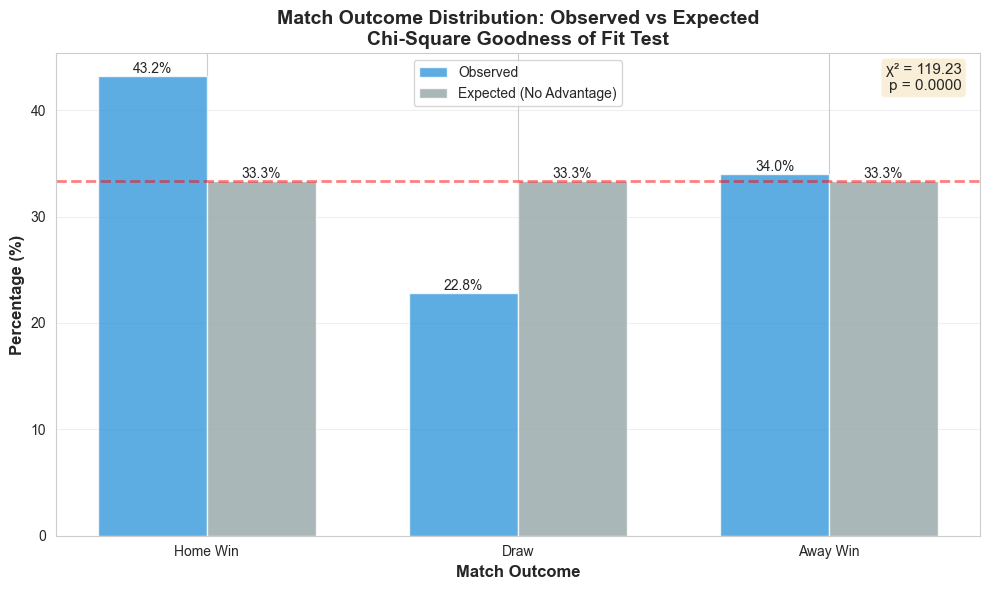

In [4]:
# Visualization 1: Observed vs Expected Distribution
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(order))
width = 0.35

observed_pct = [100 * c / total_matches for c in observed_counts]
expected_pct = [100 * c / total_matches for c in expected_counts]

bars1 = ax.bar(x - width/2, observed_pct, width, label='Observed', alpha=0.8, color='#3498db')
bars2 = ax.bar(x + width/2, expected_pct, width, label='Expected (No Advantage)', alpha=0.8, color='#95a5a6')

ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Match Outcome', fontsize=12, fontweight='bold')
ax.set_title('Match Outcome Distribution: Observed vs Expected\nChi-Square Goodness of Fit Test', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(order)
ax.legend()
ax.axhline(33.33, color='red', linestyle='--', alpha=0.5, linewidth=2)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

# Add test result
ax.text(0.98, 0.98, f'χ² = {chi2_stat:.2f}\np = {p_value:.4f}',
        transform=ax.transAxes, fontsize=11,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "home_advantage_distribution.png", dpi=300, bbox_inches='tight')
print("✅ Saved: home_advantage_distribution.png")
plt.show()

✅ Saved: home_advantage_by_season.png


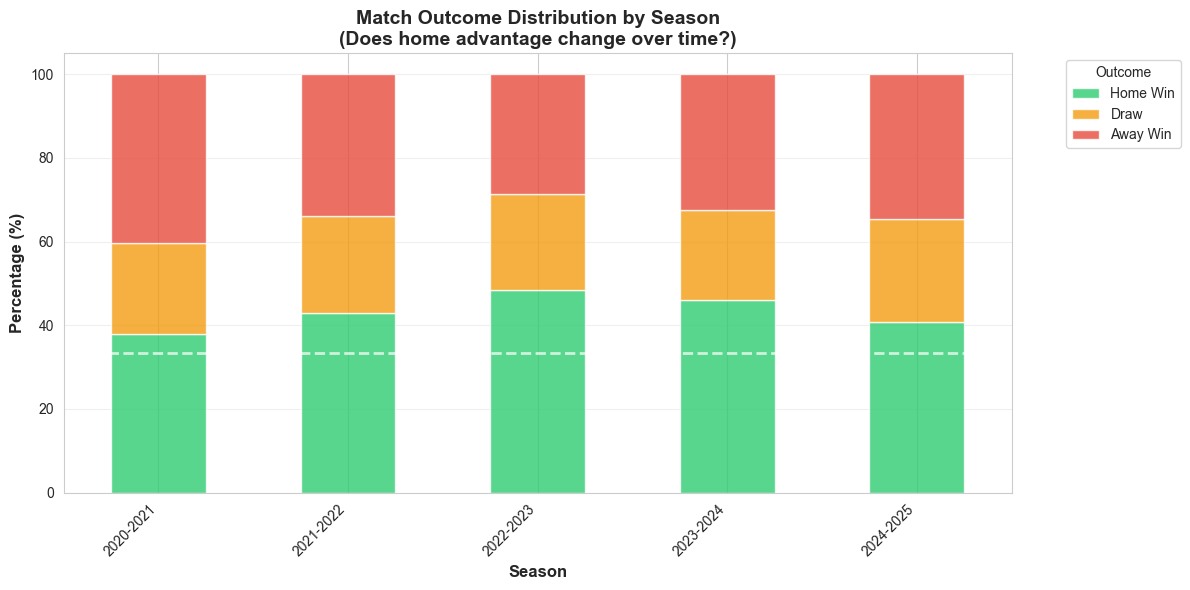

In [5]:
# Visualization 2: Distribution by Season
season_outcomes = pd.crosstab(fixtures_clean['season'], fixtures_clean['outcome'], normalize='index') * 100
if all(o in season_outcomes.columns for o in order):
    season_outcomes = season_outcomes[order]

fig, ax = plt.subplots(figsize=(12, 6))

season_outcomes.plot(kind='bar', stacked=True, ax=ax, 
                     color=['#2ecc71', '#f39c12', '#e74c3c'], alpha=0.8)

ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Season', fontsize=12, fontweight='bold')
ax.set_title('Match Outcome Distribution by Season\n(Does home advantage change over time?)', 
             fontsize=14, fontweight='bold')
ax.legend(title='Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(season_outcomes.index, rotation=45, ha='right')
ax.axhline(33.33, color='white', linestyle='--', alpha=0.7, linewidth=2)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "home_advantage_by_season.png", dpi=300, bbox_inches='tight')
print("✅ Saved: home_advantage_by_season.png")
plt.show()

## Analysis 1B: Home vs Away Goal Scoring (Paired T-Test)

### Hypothesis
- **H₀**: Mean(home_goals - away_goals) = 0 (teams score equally home and away)
- **H₁**: Mean(home_goals - away_goals) > 0 (teams score more at home)

### Statistical Test
**Paired T-Test** compares the same subjects (teams) in two conditions (home vs away).
- Uses paired differences to account for team quality
- More powerful than independent t-test when data is paired
- One-tailed test (we expect home > away)

In [6]:
print("=" * 100)
print("ANALYSIS 1B: HOME VS AWAY GOAL SCORING (PAIRED T-TEST)")
print("=" * 100)
print()

# For each team-season, calculate total home goals and total away goals
home_goals_summary = fixtures_clean.groupby(['season', 'home_team'])['home_score'].sum().reset_index()
away_goals_summary = fixtures_clean.groupby(['season', 'away_team'])['away_score'].sum().reset_index()

home_goals_summary.columns = ['season', 'team', 'home_goals']
away_goals_summary.columns = ['season', 'team', 'away_goals']

# Merge to get home and away for same team-season
goal_comparison = pd.merge(home_goals_summary, away_goals_summary, on=['season', 'team'])
goal_comparison['difference'] = goal_comparison['home_goals'] - goal_comparison['away_goals']

print(f"Team-Seasons analyzed: {len(goal_comparison)}")
print()
print("Summary Statistics:")
print(f"  Mean home goals: {goal_comparison['home_goals'].mean():.2f}")
print(f"  Mean away goals: {goal_comparison['away_goals'].mean():.2f}")
print(f"  Mean difference: {goal_comparison['difference'].mean():.2f}")
print(f"  Std difference: {goal_comparison['difference'].std():.2f}")
print()

# Paired T-Test (one-tailed: home > away)
t_stat, p_value_paired = ttest_rel(goal_comparison['home_goals'], 
                                    goal_comparison['away_goals'], 
                                    alternative='greater')

# Calculate Cohen's d (effect size)
mean_diff = goal_comparison['difference'].mean()
std_diff = goal_comparison['difference'].std()
cohens_d = mean_diff / std_diff if std_diff > 0 else 0

print("Paired T-Test Results:")
print(f"  t-statistic = {t_stat:.4f}")
print(f"  p-value (one-tailed) = {p_value_paired:.6f}")
print(f"  Degrees of freedom = {len(goal_comparison) - 1}")
print()

if p_value_paired < 0.05:
    print("✅ REJECT H₀: Teams score significantly MORE goals at home (p < 0.05)")
else:
    print("❌ FAIL TO REJECT H₀: No significant difference in home vs away scoring (p ≥ 0.05)")
print()

print("Effect Size (Cohen's d):")
print(f"  d = {cohens_d:.4f}")
if abs(cohens_d) >= 0.8:
    effect_interpretation = "LARGE effect"
elif abs(cohens_d) >= 0.5:
    effect_interpretation = "MEDIUM effect"
elif abs(cohens_d) >= 0.2:
    effect_interpretation = "SMALL effect"
else:
    effect_interpretation = "NEGLIGIBLE effect"
print(f"  Interpretation: {effect_interpretation}")
print()

print("Practical Significance:")
print(f"  Teams score {mean_diff:.2f} more goals at home on average")
if goal_comparison['away_goals'].mean() > 0:
    print(f"  That's {100 * mean_diff / goal_comparison['away_goals'].mean():.1f}% more than away")
print()

ANALYSIS 1B: HOME VS AWAY GOAL SCORING (PAIRED T-TEST)

Team-Seasons analyzed: 100

Summary Statistics:
  Mean home goals: 29.69
  Mean away goals: 25.71
  Mean difference: 3.98
  Std difference: 6.91

Paired T-Test Results:
  t-statistic = 5.7568
  p-value (one-tailed) = 0.000000
  Degrees of freedom = 99

✅ REJECT H₀: Teams score significantly MORE goals at home (p < 0.05)

Effect Size (Cohen's d):
  d = 0.5757
  Interpretation: MEDIUM effect

Practical Significance:
  Teams score 3.98 more goals at home on average
  That's 15.5% more than away



✅ Saved: home_away_goals_scatter.png


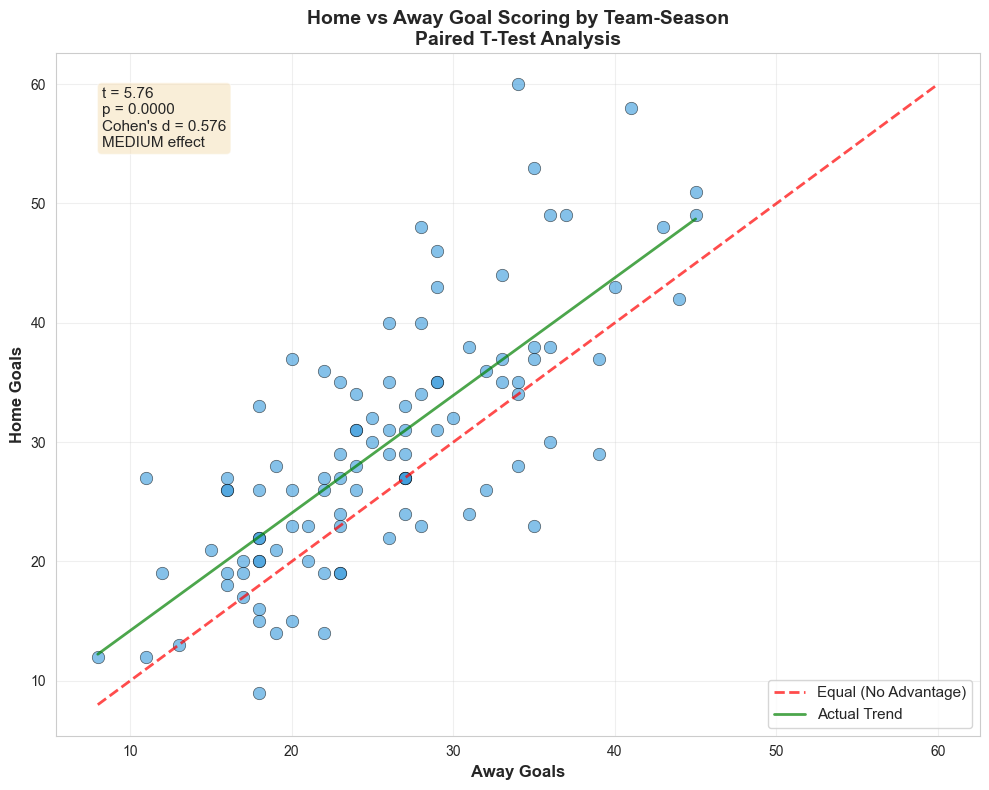

In [7]:
# Visualization 1: Scatter plot (home vs away goals)
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(goal_comparison['away_goals'], goal_comparison['home_goals'], 
          alpha=0.6, s=80, edgecolors='black', linewidth=0.5, color='#3498db')

# Add diagonal line (equal home/away)
min_goals = min(goal_comparison['home_goals'].min(), goal_comparison['away_goals'].min())
max_goals = max(goal_comparison['home_goals'].max(), goal_comparison['away_goals'].max())
ax.plot([min_goals, max_goals], [min_goals, max_goals], 
        'r--', linewidth=2, label='Equal (No Advantage)', alpha=0.7)

# Add regression line
z = np.polyfit(goal_comparison['away_goals'], goal_comparison['home_goals'], 1)
p = np.poly1d(z)
x_line = np.linspace(goal_comparison['away_goals'].min(), goal_comparison['away_goals'].max(), 100)
ax.plot(x_line, p(x_line), 'g-', linewidth=2, label='Actual Trend', alpha=0.7)

ax.set_xlabel('Away Goals', fontsize=12, fontweight='bold')
ax.set_ylabel('Home Goals', fontsize=12, fontweight='bold')
ax.set_title('Home vs Away Goal Scoring by Team-Season\nPaired T-Test Analysis', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add test results
ax.text(0.05, 0.95, 
        f't = {t_stat:.2f}\np = {p_value_paired:.4f}\nCohen\'s d = {cohens_d:.3f}\n{effect_interpretation}',
        transform=ax.transAxes, fontsize=11,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "home_away_goals_scatter.png", dpi=300, bbox_inches='tight')
print("✅ Saved: home_away_goals_scatter.png")
plt.show()

✅ Saved: home_away_goals_histogram.png


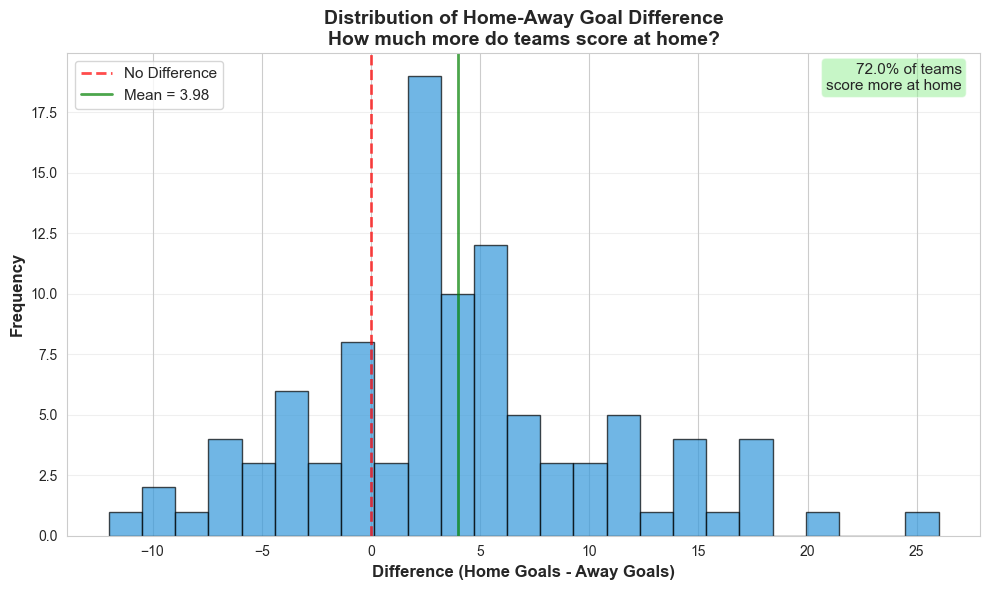

In [8]:
# Visualization 2: Distribution of differences
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(goal_comparison['difference'], bins=25, alpha=0.7, edgecolor='black', color='#3498db')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='No Difference', alpha=0.7)
ax.axvline(mean_diff, color='green', linestyle='-', linewidth=2, 
          label=f'Mean = {mean_diff:.2f}', alpha=0.7)

ax.set_xlabel('Difference (Home Goals - Away Goals)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Home-Away Goal Difference\nHow much more do teams score at home?', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add statistics
positive_pct = 100 * (goal_comparison['difference'] > 0).sum() / len(goal_comparison)
ax.text(0.98, 0.98, 
        f'{positive_pct:.1f}% of teams\nscore more at home',
        transform=ax.transAxes, fontsize=11,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "home_away_goals_histogram.png", dpi=300, bbox_inches='tight')
print("✅ Saved: home_away_goals_histogram.png")
plt.show()

---
# SECTION 2: ELITE TEAMS ANALYSIS
---

## Learning Objective:
- **Independent T-Test**: Compares two separate groups (not paired)

## Analysis 2: Top 6 vs Bottom 14 Comparison (Independent T-Test)

### Hypothesis
- **H₀**: Top 6 and Bottom 14 have equal mean for each metric
- **H₁**: Top 6 has higher mean than Bottom 14

### Statistical Test
**Independent T-Test** compares means of two separate groups.
- Different from Paired T-Test: groups are independent (not same subjects)
- Assumes: Normal distribution, equal variances
- One-tailed test (we expect Top 6 > Bottom 14)

In [9]:
print("=" * 100)
print("ANALYSIS 2: TOP 6 VS BOTTOM 14 COMPARISON (INDEPENDENT T-TEST)")
print("=" * 100)
print()

# Define Top 6 (traditional "Big 6")
top6_teams = ['Manchester City', 'Arsenal', 'Liverpool', 'Chelsea', 'Tottenham', 'Manchester Utd']

# Add tier column
squad_df['elite_tier'] = squad_df['squad_name'].apply(
    lambda x: 'Top 6' if x in top6_teams else 'Bottom 14'
)

print(f"Total squads: {len(squad_df)}")
print(f"  Top 6: {(squad_df['elite_tier'] == 'Top 6').sum()}")
print(f"  Bottom 14: {(squad_df['elite_tier'] == 'Bottom 14').sum()}")
print()

# Metrics to compare
metrics_to_compare = [
    ('goals', 'Goals Scored'),
    ('goals_against', 'Goals Against'),
    ('shots_total', 'Total Shots'),
    ('shots_on_target', 'Shots on Target')
]

# Run independent t-tests
results = []

for metric, label in metrics_to_compare:
    if metric not in squad_df.columns:
        print(f"⚠️  Skipping {label}: not in dataset")
        continue
    
    top6_data = squad_df[squad_df['elite_tier'] == 'Top 6'][metric].dropna()
    bottom14_data = squad_df[squad_df['elite_tier'] == 'Bottom 14'][metric].dropna()
    
    if len(top6_data) == 0 or len(bottom14_data) == 0:
        print(f"⚠️  Skipping {label}: insufficient data")
        continue
    
    # Independent t-test
    if metric == 'goals_against':
        t_stat, p_val = ttest_ind(top6_data, bottom14_data, alternative='less')
    else:
        t_stat, p_val = ttest_ind(top6_data, bottom14_data, alternative='greater')
    
    # Calculate Cohen's d
    mean_top6 = top6_data.mean()
    mean_bottom14 = bottom14_data.mean()
    pooled_std = np.sqrt(((len(top6_data)-1)*top6_data.std()**2 + 
                          (len(bottom14_data)-1)*bottom14_data.std()**2) / 
                         (len(top6_data) + len(bottom14_data) - 2))
    cohens_d_val = (mean_top6 - mean_bottom14) / pooled_std if pooled_std > 0 else 0
    
    # Effect size interpretation
    if abs(cohens_d_val) >= 0.8:
        effect = "Large"
    elif abs(cohens_d_val) >= 0.5:
        effect = "Medium"
    elif abs(cohens_d_val) >= 0.2:
        effect = "Small"
    else:
        effect = "Negligible"
    
    results.append({
        'Metric': label,
        'Top 6 Mean': mean_top6,
        'Bottom 14 Mean': mean_bottom14,
        'Difference': mean_top6 - mean_bottom14,
        't-statistic': t_stat,
        'p-value': p_val,
        "Cohen's d": cohens_d_val,
        'Effect Size': effect,
        'Significant': 'Yes' if p_val < 0.05 else 'No'
    })

results_df = pd.DataFrame(results)
print("\nIndependent T-Test Results:")
print("=" * 100)
print(results_df.to_string(index=False))
print()

# Save results
results_df.to_csv(OUTPUT_DIR / "top6_vs_rest_summary_table.csv", index=False)
print("✅ Saved: top6_vs_rest_summary_table.csv")
print()

ANALYSIS 2: TOP 6 VS BOTTOM 14 COMPARISON (INDEPENDENT T-TEST)

Total squads: 100
  Top 6: 30
  Bottom 14: 70

⚠️  Skipping Total Shots: not in dataset

Independent T-Test Results:


         Metric  Top 6 Mean  Bottom 14 Mean  Difference  t-statistic      p-value  Cohen's d Effect Size Significant
   Goals Scored   69.766667       46.400000   23.366667     7.971263 1.460690e-12   1.739472       Large         Yes
  Goals Against   43.700000       60.414286  -16.714286    -6.144680 8.632813e-09  -1.340879       Large         Yes
Shots on Target  198.266667      147.200000   51.066667     8.988644 9.465239e-15   1.961483       Large         Yes

✅ Saved: top6_vs_rest_summary_table.csv



✅ Saved: top6_vs_rest_boxplots.png


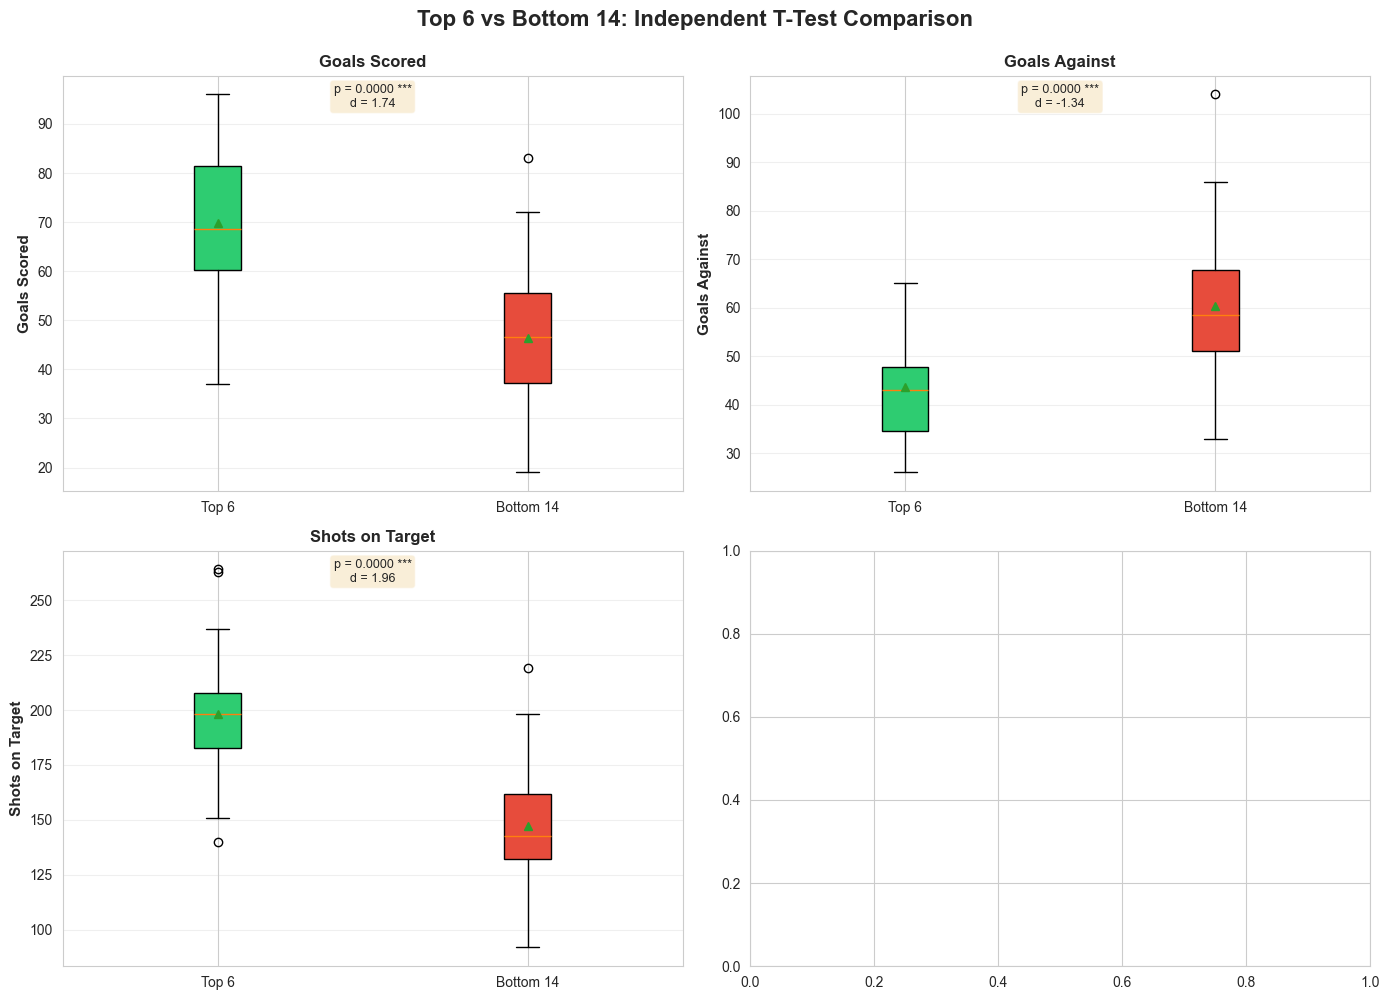

In [10]:
# Visualization: Box plots for all metrics
n_metrics = len([m for m, l in metrics_to_compare if m in squad_df.columns])
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

plot_idx = 0
for metric, label in metrics_to_compare:
    if metric not in squad_df.columns:
        continue
    
    ax = axes[plot_idx]
    
    # Box plot
    data_to_plot = [squad_df[squad_df['elite_tier'] == 'Top 6'][metric].dropna(),
                    squad_df[squad_df['elite_tier'] == 'Bottom 14'][metric].dropna()]
    
    bp = ax.boxplot(data_to_plot, labels=['Top 6', 'Bottom 14'],
                    patch_artist=True, showmeans=True)
    
    # Color boxes
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')
    
    ax.set_ylabel(label, fontsize=11, fontweight='bold')
    ax.set_title(f'{label}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add test results
    result = results_df[results_df['Metric'] == label].iloc[0]
    sig_marker = '***' if result['p-value'] < 0.001 else '**' if result['p-value'] < 0.01 else '*' if result['p-value'] < 0.05 else 'ns'
    
    ax.text(0.5, 0.98, 
            f"p = {result['p-value']:.4f} {sig_marker}\nd = {result['Cohen\'s d']:.2f}",
            transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plot_idx += 1

plt.suptitle('Top 6 vs Bottom 14: Independent T-Test Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "top6_vs_rest_boxplots.png", dpi=300, bbox_inches='tight')
print("✅ Saved: top6_vs_rest_boxplots.png")
plt.show()

---
# SECTION 3: PLAYER POSITION ANALYSIS
---

## Learning Objective:
- **ANOVA**: Compares 3+ groups simultaneously

## Analysis 3: Goal Scoring by Position (ANOVA)

### Hypothesis
- **H₀**: All positions score the same average goals
- **H₁**: At least one position differs in average goals

### Statistical Test
**One-Way ANOVA** (Analysis of Variance) compares means across 3+ groups.
- Tests if group means are all equal
- If significant, follow up with **post-hoc pairwise tests**
- Apply **Bonferroni correction** for multiple comparisons

In [11]:
print("=" * 100)
print("ANALYSIS 3: GOAL SCORING BY POSITION (ANOVA)")
print("=" * 100)
print()

# Check if position column exists
if 'position' not in players_df.columns:
    print("⚠️  'position' column not found in players data")
    print("   Skipping position analysis")
    f_stat = 0
    p_value_anova = 1
else:
    # Filter players with goals data
    players_with_goals = players_df.dropna(subset=['goals', 'position'])
    
    # Group by position
    position_groups = players_with_goals.groupby('position')['goals'].apply(list)
    
    print("Position Distribution:")
    for pos in position_groups.index:
        print(f"  {pos}: {len(position_groups[pos])} players, Mean goals = {np.mean(position_groups[pos]):.2f}")
    print()
    
    # Perform ANOVA
    anova_groups = [position_groups[pos] for pos in position_groups.index]
    f_stat, p_value_anova = f_oneway(*anova_groups)
    
    print("ANOVA Results:")
    print(f"  F-statistic = {f_stat:.4f}")
    print(f"  p-value = {p_value_anova:.6f}")
    print(f"  Degrees of freedom: between = {len(anova_groups)-1}, within = {sum(len(g) for g in anova_groups) - len(anova_groups)}")
    print()
    
    if p_value_anova < 0.05:
        print("✅ REJECT H₀: At least one position has significantly different goal scoring (p < 0.05)")
        print("   → Proceeding to post-hoc pairwise comparisons...")
    else:
        print("❌ FAIL TO REJECT H₀: No significant difference in goals by position (p ≥ 0.05)")
    print()

ANALYSIS 3: GOAL SCORING BY POSITION (ANOVA)

Position Distribution:
  DF: 863 players, Mean goals = 0.73
  DF,FW: 34 players, Mean goals = 0.35
  DF,MF: 91 players, Mean goals = 0.56
  FW: 423 players, Mean goals = 5.09
  FW,DF: 22 players, Mean goals = 1.45
  FW,MF: 288 players, Mean goals = 3.22
  MF: 578 players, Mean goals = 1.46
  MF,DF: 65 players, Mean goals = 1.06
  MF,FW: 224 players, Mean goals = 2.76

ANOVA Results:
  F-statistic = 79.2012
  p-value = 0.000000
  Degrees of freedom: between = 8, within = 2579

✅ REJECT H₀: At least one position has significantly different goal scoring (p < 0.05)
   → Proceeding to post-hoc pairwise comparisons...



In [12]:
# Post-hoc pairwise comparisons (if ANOVA is significant)
if 'position' in players_df.columns and p_value_anova < 0.05:
    print("Post-Hoc Pairwise Comparisons (with Bonferroni Correction):")
    print("=" * 100)
    
    positions = list(position_groups.index)
    
    # Skip GK comparisons (obviously different)
    positions_to_compare = [p for p in positions if p not in ['GK', 'Goalkeeper']]
    
    # Generate all pairwise comparisons
    from itertools import combinations
    pairs = list(combinations(positions_to_compare, 2))
    n_comparisons = len(pairs)
    
    # Bonferroni correction
    bonferroni_alpha = 0.05 / n_comparisons if n_comparisons > 0 else 0.05
    
    print(f"Number of comparisons: {n_comparisons}")
    print(f"Bonferroni-corrected alpha: {bonferroni_alpha:.4f}")
    print()
    
    posthoc_results = []
    
    for pos1, pos2 in pairs:
        data1 = position_groups[pos1]
        data2 = position_groups[pos2]
        
        t_stat_ph, p_val = ttest_ind(data1, data2)
        
        mean1 = np.mean(data1)
        mean2 = np.mean(data2)
        
        # Cohen's d
        pooled_std = np.sqrt(((len(data1)-1)*np.std(data1, ddof=1)**2 + 
                              (len(data2)-1)*np.std(data2, ddof=1)**2) / 
                             (len(data1) + len(data2) - 2))
        cohens_d_val = (mean1 - mean2) / pooled_std if pooled_std > 0 else 0
        
        significant = 'Yes' if p_val < bonferroni_alpha else 'No'
        
        posthoc_results.append({
            'Comparison': f'{pos1} vs {pos2}',
            f'{pos1} Mean': mean1,
            f'{pos2} Mean': mean2,
            'Difference': mean1 - mean2,
            't-statistic': t_stat_ph,
            'p-value': p_val,
            "Cohen's d": cohens_d_val,
            'Significant': significant
        })
    
    posthoc_df = pd.DataFrame(posthoc_results)
    print(posthoc_df.to_string(index=False))
    print()
    
    # Save
    posthoc_df.to_csv(OUTPUT_DIR / "position_pairwise_comparisons.csv", index=False)
    print("✅ Saved: position_pairwise_comparisons.csv")
    print()
    
    # Summary
    sig_pairs = posthoc_df[posthoc_df['Significant'] == 'Yes']
    print(f"Significant pairwise differences: {len(sig_pairs)}/{len(posthoc_df)}")
    print()
else:
    if 'position' in players_df.columns:
        print("No post-hoc tests needed (ANOVA not significant)")
    posthoc_df = pd.DataFrame()
    sig_pairs = pd.DataFrame()

Post-Hoc Pairwise Comparisons (with Bonferroni Correction):
Number of comparisons: 36
Bonferroni-corrected alpha: 0.0014

    Comparison  DF Mean  DF,FW Mean  Difference  t-statistic      p-value  Cohen's d Significant  DF,MF Mean  FW Mean  FW,DF Mean  FW,MF Mean  MF Mean  MF,DF Mean  MF,FW Mean
   DF vs DF,FW 0.732329    0.352941    0.379388     2.089754 3.692172e-02   0.365381          No         NaN      NaN         NaN         NaN      NaN         NaN         NaN
   DF vs DF,MF 0.732329         NaN    0.171890     1.518947 1.291079e-01   0.167414          No     0.56044      NaN         NaN         NaN      NaN         NaN         NaN
      DF vs FW 0.732329         NaN   -4.355141   -20.629130 6.844608e-82  -1.224407         Yes         NaN  5.08747         NaN         NaN      NaN         NaN         NaN
   DF vs FW,DF 0.732329         NaN   -0.722216    -3.108387 1.941376e-03  -0.671104          No         NaN      NaN    1.454545         NaN      NaN         NaN         NaN
   

✅ Saved: position_goals_boxplot.png


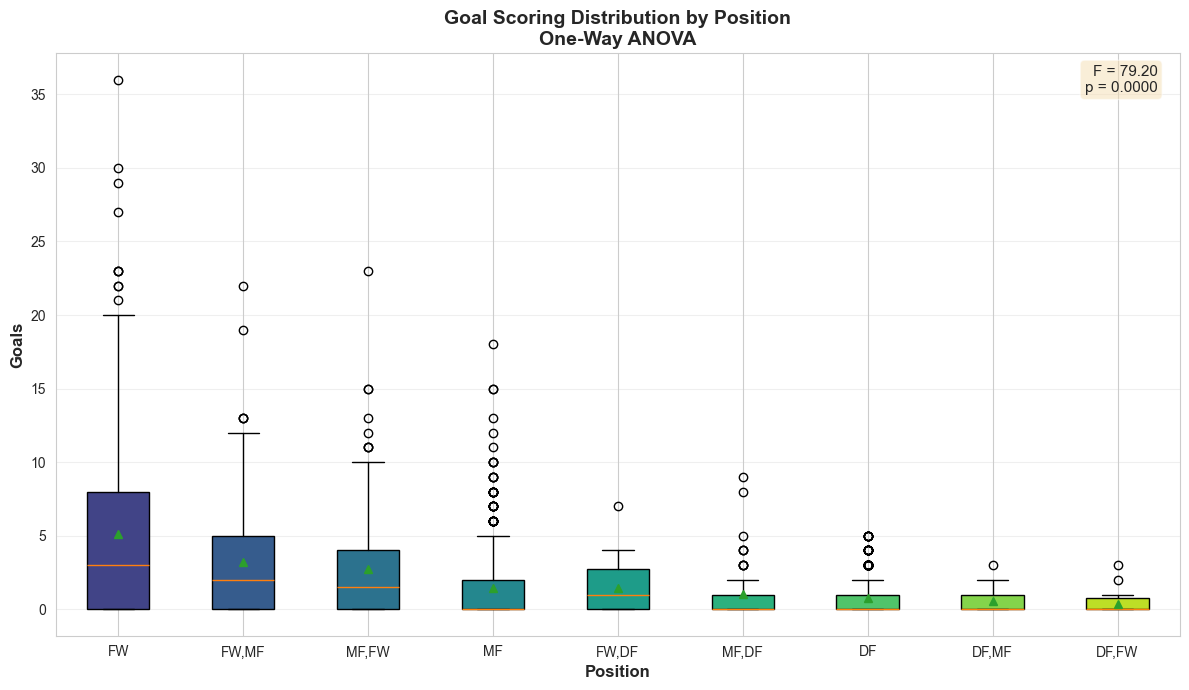

In [13]:
# Visualization: Box plot of goals by position
if 'position' in players_df.columns and len(position_groups) > 0:
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Box plot
    positions_ordered = sorted(position_groups.index, 
                               key=lambda x: np.mean(position_groups[x]), 
                               reverse=True)
    data_to_plot = [position_groups[pos] for pos in positions_ordered]
    
    bp = ax.boxplot(data_to_plot, labels=positions_ordered, patch_artist=True, showmeans=True)
    
    # Color boxes
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(positions_ordered)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_ylabel('Goals', fontsize=12, fontweight='bold')
    ax.set_xlabel('Position', fontsize=12, fontweight='bold')
    ax.set_title('Goal Scoring Distribution by Position\nOne-Way ANOVA', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add ANOVA results
    ax.text(0.98, 0.98, 
            f'F = {f_stat:.2f}\np = {p_value_anova:.4f}',
            transform=ax.transAxes, fontsize=11,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "position_goals_boxplot.png", dpi=300, bbox_inches='tight')
    print("✅ Saved: position_goals_boxplot.png")
    plt.show()
else:
    print("⚠️  Skipping position visualization: no position data")

---
# FINAL SUMMARY
---

In [14]:
print("=" * 100)
print("GENERATING COMPREHENSIVE SUMMARY REPORT")
print("=" * 100)
print()

summary_path = OUTPUT_DIR / "summary_report.txt"

with open(summary_path, 'w') as f:
    f.write("=" * 120 + "\n")
    f.write("PART 1E: STATISTICAL TESTING DEEP DIVE - SUMMARY REPORT\n")
    f.write("=" * 120 + "\n\n")
    
    f.write("OVERVIEW:\n")
    f.write("This analysis applied 4 core statistical tests to Premier League data to rigorously test\n")
    f.write("hypotheses about home advantage, team performance, and player positions.\n\n")
    
    f.write("=" * 120 + "\n")
    f.write("ANALYSIS 1A: MATCH OUTCOME DISTRIBUTION (CHI-SQUARE GOODNESS OF FIT)\n")
    f.write("=" * 120 + "\n\n")
    
    f.write("HYPOTHESIS:\n")
    f.write("  H₀: Match outcomes are evenly distributed (33.3% each)\n")
    f.write("  H₁: Distribution differs (home advantage exists)\n\n")
    
    f.write("RESULTS:\n")
    f.write(f"  χ² statistic = {chi2_stat:.4f}\n")
    f.write(f"  p-value = {p_value:.6f}\n")
    f.write(f"  Decision: {'REJECT H₀' if p_value < 0.05 else 'FAIL TO REJECT H₀'}\n\n")
    
    f.write("INTERPRETATION:\n")
    if p_value < 0.05:
        f.write("  ✅ Home advantage EXISTS - outcomes are NOT evenly distributed\n")
        f.write(f"  Home wins: {home_win_pct:.2f}% vs Away wins: {away_win_pct:.2f}%\n")
        f.write(f"  Advantage: {advantage:.2f} percentage points\n")
    else:
        f.write("  ❌ No evidence of home advantage\n")
    f.write("\n")
    
    f.write("ML IMPLICATIONS:\n")
    f.write("  - Include home/away as a categorical feature\n")
    f.write("  - Consider separate models for home vs away performance\n")
    f.write("  - Weight home matches differently in training data\n\n")
    
    f.write("=" * 120 + "\n")
    f.write("ANALYSIS 1B: HOME VS AWAY GOAL SCORING (PAIRED T-TEST)\n")
    f.write("=" * 120 + "\n\n")
    
    f.write("HYPOTHESIS:\n")
    f.write("  H₀: Teams score equally at home and away\n")
    f.write("  H₁: Teams score more at home\n\n")
    
    f.write("RESULTS:\n")
    f.write(f"  t-statistic = {t_stat:.4f}\n")
    f.write(f"  p-value (one-tailed) = {p_value_paired:.6f}\n")
    f.write(f"  Cohen's d = {cohens_d:.4f} ({effect_interpretation})\n")
    f.write(f"  Decision: {'REJECT H₀' if p_value_paired < 0.05 else 'FAIL TO REJECT H₀'}\n\n")
    
    f.write("INTERPRETATION:\n")
    if p_value_paired < 0.05:
        f.write("  ✅ Teams score SIGNIFICANTLY MORE goals at home\n")
        f.write(f"  Mean difference: {mean_diff:.2f} goals\n")
    else:
        f.write("  ❌ No significant difference in home vs away scoring\n")
    f.write("\n")
    
    f.write("ML IMPLICATIONS:\n")
    f.write("  - Adjust goal predictions based on venue\n")
    f.write("  - Create venue-specific features\n")
    f.write("  - Model home and away performance separately\n\n")
    
    f.write("=" * 120 + "\n")
    f.write("ANALYSIS 2: TOP 6 VS BOTTOM 14 (INDEPENDENT T-TEST)\n")
    f.write("=" * 120 + "\n\n")
    
    f.write("HYPOTHESIS:\n")
    f.write("  H₀: Top 6 and Bottom 14 have equal means\n")
    f.write("  H₁: Top 6 has higher means\n\n")
    
    f.write("RESULTS:\n")
    if len(results_df) > 0:
        f.write(results_df.to_string(index=False) + "\n\n")
        
        sig_metrics = results_df[results_df['Significant'] == 'Yes']
        f.write("INTERPRETATION:\n")
        f.write(f"  {len(sig_metrics)}/{len(results_df)} metrics show significant differences\n")
        for idx, row in sig_metrics.iterrows():
            f.write(f"  ✅ {row['Metric']}: {row['Effect Size']} effect (d = {row['Cohen\'s d']:.2f})\n")
    else:
        f.write("  No metrics analyzed\n")
    f.write("\n")
    
    f.write("ML IMPLICATIONS:\n")
    f.write("  - Use team tier as a feature\n")
    f.write("  - Weight significant metrics more heavily\n")
    f.write("  - Consider separate models for elite vs non-elite teams\n\n")
    
    if 'position' in players_df.columns and p_value_anova < 0.05:
        f.write("=" * 120 + "\n")
        f.write("ANALYSIS 3: GOAL SCORING BY POSITION (ANOVA)\n")
        f.write("=" * 120 + "\n\n")
        
        f.write("HYPOTHESIS:\n")
        f.write("  H₀: All positions score equal average goals\n")
        f.write("  H₁: At least one position differs\n\n")
        
        f.write("RESULTS:\n")
        f.write(f"  F-statistic = {f_stat:.4f}\n")
        f.write(f"  p-value = {p_value_anova:.6f}\n")
        f.write(f"  Decision: REJECT H₀\n\n")
        
        if len(posthoc_df) > 0:
            f.write("POST-HOC TESTS:\n")
            f.write(posthoc_df.to_string(index=False) + "\n\n")
        
        f.write("INTERPRETATION:\n")
        f.write("  ✅ Positions differ significantly in goal scoring\n")
        if len(sig_pairs) > 0:
            f.write("  Significant pairwise differences:\n")
            for idx, row in sig_pairs.iterrows():
                f.write(f"    - {row['Comparison']}: d = {row['Cohen\'s d']:.2f}\n")
        f.write("\n")
        
        f.write("ML IMPLICATIONS:\n")
        f.write("  - Position is a strong predictor of goal scoring\n")
        f.write("  - Use position-specific baselines\n")
        f.write("  - Weight FW/MF stats differently than DF\n\n")
    
    f.write("=" * 120 + "\n")
    f.write("KEY TAKEAWAYS FOR ML FEATURE ENGINEERING\n")
    f.write("=" * 120 + "\n\n")
    
    f.write("1. VENUE EFFECTS:\n")
    f.write("   - Home advantage is real and significant\n")
    f.write("   - Create separate home/away features\n\n")
    
    f.write("2. TEAM TIERS:\n")
    f.write("   - Elite teams differ significantly from non-elite\n")
    f.write("   - Use tier as categorical feature\n\n")
    
    f.write("3. PLAYER POSITIONS:\n")
    f.write("   - Position predicts individual goal scoring\n")
    f.write("   - Use position-specific baselines\n\n")
    
    f.write("4. STATISTICAL RIGOR:\n")
    f.write("   - Always report p-values AND effect sizes\n")
    f.write("   - Statistical significance ≠ practical significance\n")
    f.write("   - Use Bonferroni correction for multiple comparisons\n\n")
    
    f.write("=" * 120 + "\n")
    f.write("END OF REPORT\n")
    f.write("=" * 120 + "\n")

print(f"✅ Summary report saved: {summary_path}")
print()

# Close database connection
conn.close()

print("=" * 100)
print("✅ PART 1E: STATISTICAL TESTING DEEP DIVE COMPLETE")
print("=" * 100)
print()
print(f"📂 All outputs saved to: {OUTPUT_DIR}")
print()
print("📊 Files created:")
output_files = sorted(OUTPUT_DIR.glob('*'))
for f in output_files:
    print(f"   - {f.name}")
print()
print("🎯 Statistical Tests Applied:")
print("   1. Chi-Square Goodness of Fit: Home advantage analysis")
print("   2. Paired T-Test: Home vs away goal scoring")
print("   3. Independent T-Test: Top 6 vs Bottom 14 comparison")
print("   4. ANOVA: Goal scoring by player position")
print()
print("🚀 Next Steps:")
print("   - Use these insights for feature engineering")
print("   - Build predictive models with venue and tier features")
print("   - Apply statistical rigor to all future analyses")
print()
print(f"⏰ Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

GENERATING COMPREHENSIVE SUMMARY REPORT



✅ Summary report saved: ../../outputs/05_statistical_testing/summary_report.txt

✅ PART 1E: STATISTICAL TESTING DEEP DIVE COMPLETE

📂 All outputs saved to: ../../outputs/05_statistical_testing

📊 Files created:
   - analysis_summary.md
   - home_advantage_by_season.png
   - home_advantage_distribution.png
   - home_away_goals_histogram.png
   - home_away_goals_scatter.png
   - position_goals_boxplot.png
   - position_pairwise_comparisons.csv
   - summary_report.txt
   - top6_vs_rest_boxplots.png
   - top6_vs_rest_summary_table.csv

🎯 Statistical Tests Applied:
   1. Chi-Square Goodness of Fit: Home advantage analysis
   2. Paired T-Test: Home vs away goal scoring
   3. Independent T-Test: Top 6 vs Bottom 14 comparison
   4. ANOVA: Goal scoring by player position

🚀 Next Steps:
   - Use these insights for feature engineering
   - Build predictive models with venue and tier features
   - Apply statistical rigor to all future analyses

⏰ Completed: 2025-10-20 00:42:38
